# NLP2 project 1 IBM EM
### Mirthe van Diepen and Fabio Curi

First import required libaries.

In [1]:
import numpy as np
import pandas as pd
import tarfile
from collections import *
import matplotlib.pyplot as plt
import random
from decimal import Decimal
from matplotlib.ticker import NullFormatter  # useful for `logit` scale

from scipy import special

from itertools import accumulate

np.random.seed(19680801)

import copy
import time

## Prepare data

In [2]:
def read_data(tar, names, en_words_u = [], fr_words_u = [], en_words_k = [], fr_words_k = []):
    
    for member in tar.getmembers():
        # check if we want to read this file
        if not member.name in names: continue
        if member.name == names[0]:
            en_tr = tar.extractfile(member).readlines()
        elif member.name == names[1]:
            fr_tr = tar.extractfile(member).readlines()

    # Create dataframe
    data = pd.DataFrame({'en': en_tr,'fr': fr_tr})

    # Get strings and delete \n 
    for i in data.index:
        data.at[i, 'en'] = data.at[i, 'en'].decode("utf-8")
        data.at[i, 'fr'] = data.at[i, 'fr'].decode("utf-8")
        if ' \n' in data.at[i, 'en']:
            data.at[i, 'en'] = data.at[i, 'en'].replace(' \n','')
        if ' \n' in data.at[i, 'fr']:
            data.at[i, 'fr'] = data.at[i, 'fr'].replace(' \n','')

    # create count dictionary 
    dict_e = defaultdict(lambda: 0)
    dict_f = defaultdict(lambda: 0)
    for i in data.index:
        tokens_e = data.at[i, 'en'].split(' ')
        for token in tokens_e:
            dict_e[token] += 1
        tokens_f = data.at[i, 'fr'].split(' ')
        for token in tokens_f:
            dict_f[token] += 1
                
    # Get all bilingual sentences
    sentences_u = []
    sentences_k = []
    for x,y in zip(data['en'], data['fr']):
        sentences_u.append([x.split(),y.split()])
        sentences_k.append([x.split(),y.split()])

    if len(en_words_u) + len(fr_words_u) + len(en_words_k) + len(fr_words_k) == 0:
        for s in sentences_u:
            for i in range(len(s[0])):
                if dict_e[s[0][i]] < 5:
                    # replace rare words by 'unk'
                    s[0][i] = 'unk'
                en_words_u.append(s[0][i])
            for i in range(len(s[1])):
                if dict_f[s[1][i]] < 5:
                    # replace rare words by 'unk'
                    s[1][i] = 'unk'
                fr_words_u.append(s[1][i])
            # add null
            s[0] = ['NULL'] + s[0]
        for s in sentences_k:
            for i in range(len(s[0])):
                en_words_k.append(s[0][i])
            for i in range(len(s[1])):
                fr_words_k.append(s[1][i])
            # add null
            s[0] = ['NULL'] + s[0]
        en_words_u, fr_words_u = sorted(list(set(en_words_u))) , sorted(list(set(fr_words_u)))
        en_words_k, fr_words_k = sorted(list(set(en_words_k))) , sorted(list(set(fr_words_k)))
        print('Size of English dictionary with unknown words:', len(en_words_u))
        print('Size of French dictionary with unknown words:', len(fr_words_u))
        print('Size of English dictionary for k-smoothing:', len(en_words_k))
        print('Size of French dictionary for k-smoothing:', len(fr_words_k))
        return sentences_u, sentences_k, en_words_u, fr_words_u,  en_words_k, fr_words_k
    else:
        for s in sentences_u:
            for i in range(len(s[0])):
                if not s[0][i] in en_words_u:
                    # replace rare words by 'unk'
                    s[0][i] = 'unk'
            for i in range(len(s[1])):
                if not s[1][i] in fr_words_u:
                    # replace rare words by 'unk'
                    s[1][i] = 'unk'
            # add null
            s[0] = ['NULL'] + s[0]
            
        for s in sentences_k:
            # add null
            s[0] = ['NULL'] + s[0]
            
        return data, sentences_u, sentences_k
    

In [3]:
# Read training data
tar = tarfile.open("training.tgz", "r:gz")
names = ["training/hansards.36.2.e", "training/hansards.36.2.f"]
sentences_u, sentences_k, en_words_u, fr_words_u,  en_words_k, fr_words_k = read_data(tar, names)

# Read test data
tar = tarfile.open("testing.tgz", "r:gz")
names = ["testing/test/test.e", "testing/test/test.f"]
test_data, test_sentences_u, test_sentences_k = read_data(tar, names, en_words_u, fr_words_u,  en_words_k, fr_words_k)

# Read validation data
tar = tarfile.open("validation.tgz", "r:gz")
names = ["validation/dev.e", "validation/dev.f", "dev.wa.nonullalign"]
_, validation_sentences_u, validation_sentences_k = read_data(tar, names, en_words_u, fr_words_u,  en_words_k, fr_words_k)

Size of English dictionary with unknown words: 15867
Size of French dictionary with unknown words: 19073
Size of English dictionary for k-smoothing: 36635
Size of French dictionary for k-smoothing: 46421


## Perplexity

In [4]:
def pfe_IBM1(en, fr, t, epsilon):
    """
    Compute the log probability of a IBM model 1.
    """
    
    pef=1
    for f in fr: 
        summ = 0
        for e in en: 
            summ += t[e][f]
        pef = pef*summ
    
    nom=pef*epsilon
    den=(len(en)+1)**len(fr)
        
    pef = Decimal(nom)/Decimal(den)
    
    return float(pef)          

def perplexity_IBM1(sentences, t, epsilon):
    """
    Compute the perplexity.
    """
    
    pp = []
    for s in sentences:
        pfe = pfe_IBM1(s[0], s[1], t, epsilon) # Probability of p(f|e)
        pp.append(-np.log2(pfe))

    return np.ma.masked_invalid(pp).sum() # Give the results as log2(PP), ignoring -inf


def pfe_IBM2(en, fr, pi_t, pi_A, epsilon):
    """
    Compute the log probability of a IBM model 2.
    """
    
    l = len(en)
    m = len(fr)
    prob = epsilon
    
    for j in range(m):
        sum_prob = 0
        for i in range(l):
            e = en[i]
            f = fr[j]
            sum_prob += pi_A[l][m][j][i] * pi_t[e][f] 
        prob *= sum_prob
            
    return prob 


def perplexity_IBM2(sentences, pi_t, pi_A, epsilon):
    """
    Compute the perplexity.
    """
    
    pp = []
    for s in sentences:
        pfe = pfe_IBM2(s[0], s[1], pi_t, pi_A, epsilon) # Probability of p(f|e)
        pp.append(-np.log2(pfe))

    return np.ma.masked_invalid(pp).sum() # Give the results as log2(PP), ignoring -inf

## AER

In [5]:
# Evolution of alignment error rate (AER) on validation data as a function of the iteration.

"""
This module helps you compute AER for validation set after each iteration of EM.
Check the test function below for an example of how to use these helper functions.

For test results, please use the official AER perl script.
"""

def read_naacl_alignments(path):
    """
    Read NAACL-formatted alignment files.

    :param path: path to file
    :return: a list of pairs [sure set, possible set]
        each entry in the set maps an input position to an output position
        sentences start from 1 and a NULL token is indicated with position 0
    """
    with open(path) as fi:
        ainfo = {}
        for i, line in enumerate(fi.readlines()):
            fields = line.split()
            if not fields:
                continue
            sure = True  # by default we assumed Sure links
            prob = 1.0  # by default we assume prob 1.0
            if len(fields) < 3:
                raise ValueError('Missing required fields in line %d: %s' % (i, line.strip()))
            snt_id, x, y = int(fields[0]), int(fields[1]), int(fields[2])
            if len(fields) == 5:
                sure = fields[3] == 'S'
                prob = float(fields[4])
            if len(fields) == 4:
                if fields[3] in {'S', 'P'}:
                    sure = fields[3] == 'S'
                else:
                    prob = float(fields[3])
            snt_info = ainfo.get(snt_id, None)
            if snt_info is None:
                snt_info = [set(), set()]  # S and P sets
                ainfo[snt_id] = snt_info
            if sure:  # Note that S links are also P links: http://dl.acm.org/citation.cfm?id=992810
                snt_info[0].add((x, y))
                snt_info[1].add((x, y))
            else:
                snt_info[1].add((x, y))
    return tuple(v for k, v in sorted(ainfo.items(), key=lambda pair: pair[0]))


class AERSufficientStatistics:
    """
    Object used to compute AER for a corpus.
    """

    def __init__(self):
        self.a_and_s = 0
        self.a_and_p = 0
        self.a = 0
        self.s = 0

    def __str__(self):
        return '%s/%s/%s/%s %s' % (self.a_and_s, self.a_and_p, self.a, self.s, self.aer())

    def update(self, sure, probable, predicted):
        """
        Update AER sufficient statistics for a set of predicted links given goldstandard information.

        :param sure: set of sure links 
            a links is a tuple of 1-based positions (from, to) where 0 is reserved for NULL
        :param probable: set of probable links (must incude sure links)
        :param predicted: set of predicted links
        """
        self.a_and_s += len(predicted & sure)
        self.a_and_p += len(predicted & probable)
        self.a += len(predicted)
        self.s += len(sure)

    def aer(self):
        """Return alignment error rate: 1 - (|A & S| + |A & P|)/(|A| + |S|)"""
        return 1 - (self.a_and_s + self.a_and_p) / (self.a + self.s)


def test(path, predictions):
    
    # read in gold alignments
    gold_sets = read_naacl_alignments(path)

    # compute AER:

    # first we get an object that manages sufficient statistics 
    metric = AERSufficientStatistics()
    # then we iterate over the corpus 
    for gold, pred in zip(gold_sets, predictions):
        metric.update(sure=gold[0], probable=gold[1], predicted=pred)
    
    return metric.aer()

def all_indices(value, qlist):
    indices = []
    idx = -1
    while True:
        try:
            idx = qlist.index(value, idx+1)
            indices.append(idx)
        except ValueError:
            break
    return indices[0]

def align_IBM1(s, t):
    
    alignments=[]
    l = len(s[0])
    m = len(s[1])
    for i in range(l):
        if i==0: continue
        vals=[]
        for j in range(m):
            vals.append(t[s[0][i]][s[1][j]])
        max_idx = vals.index(max(vals))
        alignments.append((i, max_idx+1)) # try +1

    return set(alignments)

def align_IBM2(s, pi_t, pi_A):
    
    alignments=[]
    l = len(s[0])
    m = len(s[1])
    for i in range(l):
        if i==0: continue
        vals=[]
        for j in range(m):
            vals.append(pi_A[l][m][j][i] * pi_t[s[0][i]][s[1][j]])
        max_idx = vals.index(max(vals))
        alignments.append((i, max_idx+1))

    return set(alignments)

## EM for IBM Model 1

In [6]:
def EM_IBM1(sentences, val_sentences, epsilon, smoothing=False):
    """
    Run EM IBM Model 1
    INPUT:
        t: translation probabilities (defaultdict(defaultdict(float)))
        sentences: list of 2 lists; 1st contains English words (strings) and 2nd contains French words (strings)
        iterations: number of requested iterations (positive integer)
        epsilon: positive float
    OUTPUT:
        t: updated translation probabilities (defaultdict(defaultdict(float)))
        perplex_vals: the perplixity for all iterations (list of floats)
    """
    
    # Initialise the translation probabilities
    if not smoothing:
        val = 1.0 / len(fr_words_u)
        t = defaultdict(lambda: defaultdict(lambda:val))
    else:
        val = 1.0 / len(fr_words_k)
        t = defaultdict(lambda: defaultdict(lambda:val))

    perplexity_vals, AER_vals, house_maison, house_demain = [], [], [], []
    
    iterations = 10
    
    for i in range(iterations):

        print("Iteration {}".format(i))
        
        # Compute the perplexity
        perplexity_vals.append(perplexity_IBM1(sentences, t, epsilon))

        # Initialize the dictionaries
        count = defaultdict(lambda: defaultdict(lambda:0.))
        total = defaultdict(lambda:0.)

        for s in sentences:        
            
            s_total = defaultdict(lambda:0)
            
            # For every English word, compute the sum of probabilities of French words 
            # which are possible translations
            for e in s[0]:
                for f in s[1]:
                    s_total[e] += t[e][f]

            # Count the normalized total probability of French word f
            # is a translation given English word e
            for e in s[0]:
                for f in s[1]:
                    count[e][f] += t[e][f] / s_total[e]
                    total[f] += t[e][f] / s_total[e]

        for s in sentences:
            
            # Estimate the new probabilities for all word pairs
            for e in s[0]:
                for f in s[1]:
                    if smoothing: # add k-smoothing with k=5
                        k=5
                        t[e][f] = (count[e][f]+k) / (total[f] + (k*len(en_words_k)))
                    else:
                        t[e][f] = count[e][f] / total[f]
                    
                    
        # Store some results for plot
        house_maison.append(t['house']['maison'])
        house_demain.append(t['house']['demain'])
        
        # Simulation of a close-to Viterbi algorithm to calculate the AER for each iteration
        alignments=[]
        for s in val_sentences:
            alignments.append(align_IBM1(s,t))
        AER_vals.append(test('dev.wa.nonullalign', alignments))
                
        # Clear all dictionaries
        count.clear()
        total.clear()
        s_total.clear()
        
    return t, perplexity_vals, AER_vals, house_maison, house_demain

### Training

Train different models for different values for ε and k-smoothings

In [7]:
# unknown set
t_EM_IBM1_e01_u, perplexity_EM_IBM1_e01_u, AER_EM_IBM1_e01_u, house_maison_e01_u, house_demain_e01_u = EM_IBM1(sentences_u, validation_sentences_u, 0.1)
t_EM_IBM1_e05_u, perplexity_EM_IBM1_e05_u, AER_EM_IBM1_e05_u, house_maison_e05_u, house_demain_e05_u = EM_IBM1(sentences_u, validation_sentences_u, 0.05)

# k-smoothing:
t_EM_IBM1_e01_s, perplexity_EM_IBM1_e01_s, AER_EM_IBM1_e01_s, house_maison_e01_s, house_demain_e01_s = EM_IBM1(sentences_k, validation_sentences_k, 0.1, True)
t_EM_IBM1_e05_s, perplexity_EM_IBM1_e05_s, AER_EM_IBM1_e05_s, house_maison_e05_s, house_demain_e05_s = EM_IBM1(sentences_k, validation_sentences_k, 0.05, True)

Iteration 0


/Users/mmvandiepen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log2


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


In [32]:
print("The AER of IBM1 with unknown tags and epsilon 0.1 is:", AER_EM_IBM1_e01_u[-1])
print("The AER of IBM1 with unknown tags and epsilon 0.05 is:", AER_EM_IBM1_e05_u[-1])
print("The AER of IBM1 with k-smoothing and epsilon 0.1 is:", AER_EM_IBM1_e01_s[-1])
print("The AER of IBM1 with k-smoothing and epsilon 0.05 is:", AER_EM_IBM1_e05_s[-1])

The AER of IBM1 with unknown tags and epsilon 0.1 is: 0.2952952952952953
The AER of IBM1 with unknown tags and epsilon 0.05 is: 0.2952952952952953
The AER of IBM1 with k-smoothing and epsilon 0.1 is: 0.5535535535535536
The AER of IBM1 with k-smoothing and epsilon 0.05 is: 0.5535535535535536


### Experiments

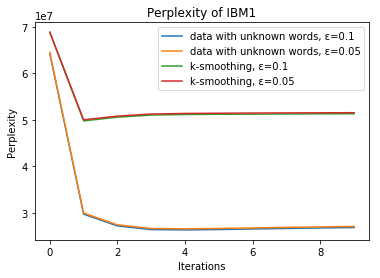

In [8]:
iterations = range(0, 10)
plt.plot(iterations, perplexity_EM_IBM1_e01_u, label="data with unknown words, ε=0.1")
plt.plot(iterations, perplexity_EM_IBM1_e05_u, label="data with unknown words, ε=0.05")
plt.plot(iterations, perplexity_EM_IBM1_e01_s, label="k-smoothing, ε=0.1")
plt.plot(iterations, perplexity_EM_IBM1_e05_s, label="k-smoothing, ε=0.05")
plt.title('Perplexity of IBM1')
plt.ylabel('Perplexity')
plt.xlabel('Iterations')
plt.legend()
plt.show()

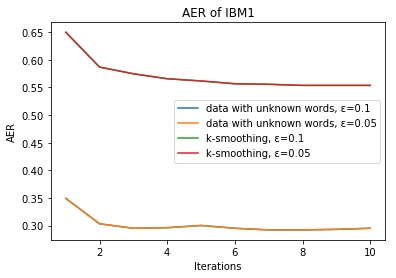

In [9]:
iterations = range(1, 11)
plt.plot(iterations, AER_EM_IBM1_e01_u, label="data with unknown words, ε=0.1")
plt.plot(iterations, AER_EM_IBM1_e05_u, label="data with unknown words, ε=0.05")
plt.plot(iterations, AER_EM_IBM1_e01_s, label="k-smoothing, ε=0.1")
plt.plot(iterations, AER_EM_IBM1_e05_s, label="k-smoothing, ε=0.05")
plt.title('AER of IBM1')
plt.ylabel('AER')
plt.xlabel('Iterations')
plt.legend()
plt.show()

$t(e\mid f)$ values for `[e=house, f=maison]` and `[e=house, f=demain]`

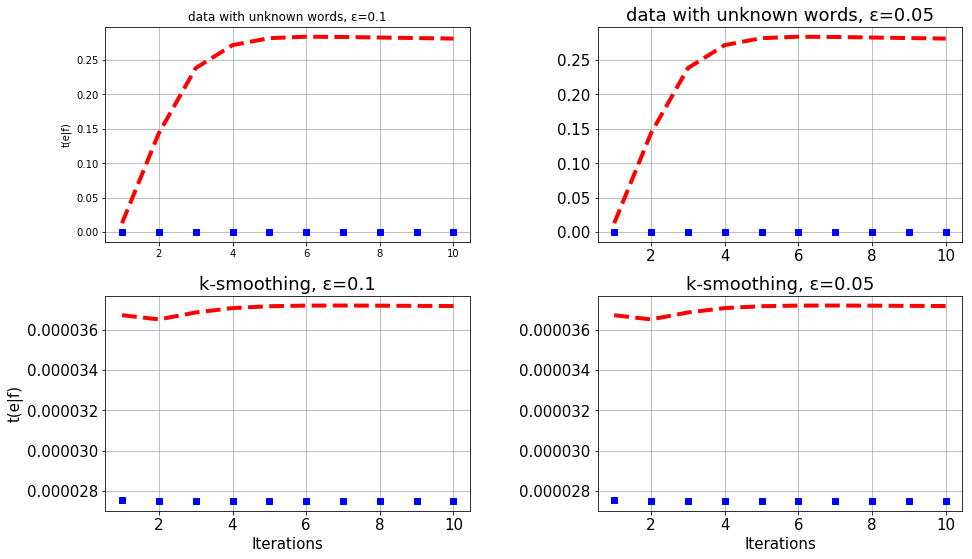

In [10]:
np.random.seed(19680801)
plt.figure(figsize=(14,8))

plt.subplot(221)
plt.plot(iterations, house_maison_e01_u, 'r--', iterations, house_demain_e01_u, 'bs', linewidth=4)
plt.ylabel('t(e|f)')
plt.title('data with unknown words, ε=0.1')
plt.rcParams.update({'font.size': 15})
plt.grid(True)

plt.subplot(222)
plt.plot(iterations, house_maison_e05_u, 'r--', iterations, house_demain_e05_u, 'bs', linewidth=4)
plt.title('data with unknown words, ε=0.05')
plt.rcParams.update({'font.size': 15})
plt.grid(True)

plt.subplot(223)
plt.plot(iterations, house_maison_e01_s, 'r--', iterations, house_demain_e01_s, 'bs', linewidth=4)
plt.title('k-smoothing, ε=0.1')
plt.ylabel('t(e|f)')
plt.xlabel('Iterations')
plt.rcParams.update({'font.size': 15})
plt.grid(True)

plt.subplot(224)
plt.plot(iterations, house_maison_e05_s, 'r--', iterations, house_demain_e05_s, 'bs', linewidth=4)
plt.xlabel('Iterations')
plt.title('k-smoothing, ε=0.05')
plt.rcParams.update({'font.size': 15})
plt.grid(True)


plt.gca().yaxis.set_minor_formatter(NullFormatter())
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()

### Create NAACL file

In [16]:
def create_naacl_IBM1(t, test_sentences, path):
    f = open(path, "w+")
    N = len(test_sentences)
    for n, s in enumerate(test_sentences):
        l = len(s[0])
        m = len(s[1])
        for i in range(l):
            if i==0: continue
            vals=[]
            for j in range(m):
                vals.append(t[s[0][i]][s[1][j]])
            max_idx = vals.index(max(vals))
            if n==N-1 and i==l-1 and j==m-1:
                f.write("{} {} {} S".format(n+1, i, max_idx+1))
            else:
                f.write("{} {} {} S\n".format(n+1, i, max_idx+1))
    f.close()

In [17]:
create_naacl_IBM1(t_EM_IBM1_e01_u, validation_sentences_u, "ibm1.mle.naacl")

## EM IBM 2 

The alignment probs are in dictionary: 

`pi_A = [length l of english sentence e][length m of french sentence f][jth word in f][ith word in e]`

In [18]:
def EM_IBM2(pi_t, pi_A, sentences, val_sentences, epsilon, smoothing=False):
    """
    Run EM IBM Model 2
    INPUT:
        pi_t: translation probabilities (defaultdict(defaultdict(float)))
        pi_A: alignments defaultdict: 
        sentences: list of 2 lists; 1st contains English words (strings) and 2nd contains French words (strings)
        iterations: number of requested iterations (positive integer)
        epsilon: positive float near zero
    OUTPUT:
        pi_t: updated translation probabilities (defaultdict(defaultdict(float)))
        pi_A: updated allignments
        perplex_vals: the perplixity for all iterations (list of floats)
    """
    
    
    perplexity_vals = []
    AER_vals = []
    iterations = 10
    
    for i in range(iterations):
        
        print("Iteration {}".format(i))
        
        # compute perplexity
        perplexity_val = perplexity_IBM2(sentences, pi_t, pi_A, epsilon)
        perplexity_vals.append(perplexity_val)

        # set all counts to zero
        count_pairs = defaultdict(lambda: defaultdict(lambda:0.))
        count_total = defaultdict(lambda:0.)
        count_cond = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda:0.))))
        count_prior = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda:0)))
        
        for s in sentences:
        
            # initialize s_total
            s_total = defaultdict(lambda:0)
            
            l = len(s[0])
            m = len(s[1])

            # for every English word compute the sum of probabilities
            # of French words which are possible translations
            for i in range(l):
                for j in range(m):
                    e = s[0][i]
                    f = s[1][j]
                    s_total[f] += pi_A[l][m][j][i] * pi_t[e][f]

            # count the normalized total probability of French word f
            # is a translation given English word e
            for i in range(l):
                for j in range(m):
                    e = s[0][i]
                    f = s[1][j]
                    delta = pi_A[l][m][j][i] * pi_t[e][f] / s_total[f]
                    count_pairs[e][f] += delta
                    count_total[e] += delta
                    count_cond[l][m][j][i] += delta
                    count_prior[l][m][j] += delta
            
            # clear s_total
            s_total.clear()
        
        # estimate the new probabilities for all word pairs and all alignments
        pi_t.clear()
        pi_A.clear()
        pi_t = defaultdict(lambda: defaultdict(lambda:0.))
        pi_A = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda:0.))))
        for s in sentences:
            l = len(s[0])
            m = len(s[1])
            for i in range(l):
                for j in range(m):
                    e = s[0][i]
                    f = s[1][j]
                    if smoothing: # add k-smoothing with k=5
                        k=5
                        pi_t[e][f] = (count_pairs[e][f]+k) / (count_total[e]+k*len(en_words_k))
                    else:
                        pi_t[e][f] = count_pairs[e][f] / count_total[e]
                    pi_A[l][m][j][i] = count_cond[l][m][j][i] / count_prior[l][m][j]

        
        # Simulation of a close-to Viterbi algorithm to calculate the AER for each iteration
        alignments=[]
        for s in val_sentences:
            alignments.append(align_IBM2(s, pi_t, pi_A))
        AER_vals.append(test('dev.wa.nonullalign', alignments))
        
        # clear all counts
        count_pairs.clear()
        count_total.clear()
        count_cond.clear()
        count_prior.clear()
                
    print("Finished training\n")
                
    return pi_t, pi_A, perplexity_vals, AER_vals

### Initialize and train uniform IBM2

In [19]:
class uniform_dict_A(defaultdict):
    def __init__(self, f_of_x):
        super().__init__(None)
        self.f_of_x = f_of_x
        
    def __missing__(self, key):
        value = self.f_of_x(key)
        self[key] = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: value)))
        return self[key]

In [21]:
# initialize uniform pi_t and pi_A
start = time.time()
val = 1.0 / len(fr_words_u)
pi_t_U = defaultdict(lambda: defaultdict(lambda:val))
pi_A_U1 = uniform_dict_A(lambda x: 1/x)
pi_A_U2 = uniform_dict_A(lambda x: 1/x)
for s in sentences_u:
    l = len(s[0])
    m = len(s[1])
    for j in range(m):
        for i in range(l):
            pi_t_U[s[0][i]][s[1][j]]
            pi_A_U1[l][m][j][i]
            pi_A_U2[l][m][j][i]
            
end = time.time()
print("Initialization of pi_t and pi_A uniform: ", end-start)

Initialization of pi_t and pi_A uniform:  154.30978918075562


In [28]:
epsilon = 0.1
pi_t_EM_IBM2_U, pi_A_EM_IBM2_U, perplexity_EM_IBM2_U, AER_EM_IBM2_U = EM_IBM2(pi_t_U, pi_A_U1, sentences_u, validation_sentences_u, epsilon, False)


Iteration 0


/Users/mmvandiepen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Finished training



In [29]:
pi_t_U2 = t_EM_IBM1_e01_u.copy()
pi_t_EM_IBM2_UM1, pi_A_EM_IBM2_UM1, perplexity_EM_IBM2_UM1, AER_EM_IBM2_UM1 = EM_IBM2(pi_t_U2, pi_A_U2, sentences_u, validation_sentences_u, epsilon, False)


Iteration 0


/Users/mmvandiepen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Finished training



### Initialize and train random IBM2

In [23]:
start = time.time()

pi_A_R_1 = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0))))
pi_A_R_2 = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0))))
for s in sentences_u:
    l = len(s[0])
    m = len(s[1])
    for j in range(m):
        random_list = np.random.rand(l)
        random_list = random_list/sum(random_list)
        random_list = random_list.tolist()
        for i in range(l):
            value = np.random.choice(random_list)
            random_list.remove(value)
            pi_A_R_1[l][m][j][i] = value
            pi_A_R_2[l][m][j][i] = value            

pi_t_R = defaultdict(lambda: defaultdict(lambda: 0.))
sum_vals_u = defaultdict(lambda:0.)
for s in sentences_u:
    for e in s[0]:
        for f in s[1]:
            pi_t_R[e][f] = random.uniform(0.1,0.9)
            sum_vals_u[e] += pi_t_R[e][f]
for e in pi_t_R.keys():
    for f in pi_t_R[e].keys():
        pi_t_R[e][f] /= sum_vals_u[e]
        
end = time.time()
print("Initialization of pi_t and pi_A random: ", end-start)

Initialization of pi_t and pi_A random:  952.709331035614


In [30]:
epsilon = 0.1
pi_t_EM_IBM2_R, pi_A_EM_IBM2_R, perplexity_EM_IBM2_R, AER_EM_IBM2_R = EM_IBM2(pi_t_R, pi_A_R_1, sentences_u, validation_sentences_u, epsilon, False)


Iteration 0


/Users/mmvandiepen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Finished training



In [31]:
pi_t_R2 = t_EM_IBM1_e01_u.copy()
pi_t_EM_IBM2_RM1, pi_A_EM_IBM2_RM1, perplexity_EM_IBM2_RM1, AER_EM_IBM2_RM1 = EM_IBM2(pi_t_R2, pi_A_R_2, sentences_u, validation_sentences_u, epsilon, False)


Iteration 0


/Users/mmvandiepen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Finished training



### Experiments

In [35]:
print("The AER of IBM2 with t: uniform and a: uniform is:", AER_EM_IBM2_U[-1])
print("The AER of IBM2 with t: IBM model 1 and a: uniform is:", AER_EM_IBM2_UM1[-1])
print("The AER of IBM2 with t: random and a: random is:", AER_EM_IBM2_R[-1])
print("The AER of IBM2 with t: IBM model 1 and a: random is:", AER_EM_IBM2_RM1[-1])

The AER of IBM2 with t: uniform and a: uniform is: 0.2912912912912913
The AER of IBM2 with t: IBM model 1 and a: uniform is: 0.26626626626626626
The AER of IBM2 with t: random and a: random is: 0.2992992992992993
The AER of IBM2 with t: IBM model 1 and a: random is: 0.26626626626626626


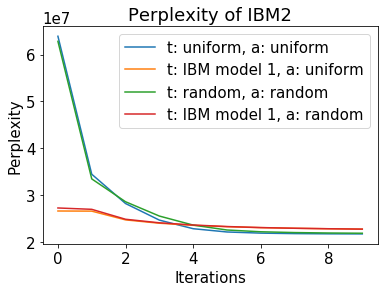

In [33]:
iterations = range(0, 10)
plt.plot(iterations, perplexity_EM_IBM2_U, label="t: uniform, a: uniform")
plt.plot(iterations, perplexity_EM_IBM2_UM1, label="t: IBM model 1, a: uniform")
plt.plot(iterations, perplexity_EM_IBM2_R, label="t: random, a: random")
plt.plot(iterations, perplexity_EM_IBM2_RM1, label="t: IBM model 1, a: random")
plt.title('Perplexity of IBM2')
plt.ylabel('Perplexity')
plt.xlabel('Iterations')
plt.legend()
plt.show()

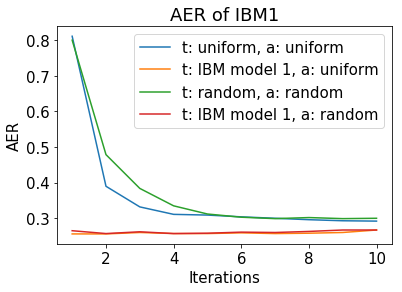

In [34]:
iterations = range(1, 11)
plt.plot(iterations, AER_EM_IBM2_U, label="t: uniform, a: uniform")
plt.plot(iterations, AER_EM_IBM2_UM1, label="t: IBM model 1, a: uniform")
plt.plot(iterations, AER_EM_IBM2_R, label="t: random, a: random")
plt.plot(iterations, AER_EM_IBM2_RM1, label="t: IBM model 1, a: random")
plt.title('AER of IBM1')
plt.ylabel('AER')
plt.xlabel('Iterations')
plt.legend()
plt.show()

## Create NAACL file

In [38]:
def create_naacl_IBM2(pi_t, pi_A, test_sentences, path):
    f = open(path, "w+")
    N = len(test_sentences)
    for n, s in enumerate(test_sentences):
        l = len(s[0])
        m = len(s[1])
        for i in range(l):
            if i==0: continue
            vals=[]
            for j in range(m):
                vals.append(pi_A[l][m][j][i] * pi_t[s[0][i]][s[1][j]])
            max_idx = vals.index(max(vals))
            if n==N-1 and i==l-1 and j==m-1:
                f.write("{} {} {} S".format(n+1, i, max_idx+1))
            else:
                f.write("{} {} {} S\n".format(n+1, i, max_idx+1))
    f.close()

In [39]:
create_naacl_IBM2(pi_t_EM_IBM2_UM1, pi_A_EM_IBM2_UM1, test_sentences_u, "ibm2.mle.naacl")